In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels as sm
import seaborn as sns

In [2]:
from platform import python_version
print(python_version())

3.11.4


In [3]:
# Set a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

In [58]:
import statistics_utils as su
import visualization_utils as vu
import scaling_transform as st

#### Data Reading and Column Analysis

In [5]:
import os
print(os.listdir("Data"))

['Student_Performance.csv']


In [6]:
st_pf = pd.read_csv(r"Data\Student_Performance.csv")

In [7]:
st_pf.head(4)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0


In [8]:
st_pf.shape

(10000, 6)

In [9]:
st_pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


Clearly Observance : 
    1) Dependent Variable - Perfomance Index
    2) Categorical - Extracurricular Activities, rest continuous. 
    3) Data type of the P.I should be taken care of

In [10]:
categorical_columns = ["Extracurricular Activities"]
continuous_columns = [x for x in st_pf.columns if x not in categorical_columns]

categorical_columns, continuous_columns

(['Extracurricular Activities'],
 ['Hours Studied',
  'Previous Scores',
  'Sleep Hours',
  'Sample Question Papers Practiced',
  'Performance Index'])

In [11]:
target = ["Performance Index"]
feature = [x for x in st_pf.columns if x not in target]

target, feature

(['Performance Index'],
 ['Hours Studied',
  'Previous Scores',
  'Extracurricular Activities',
  'Sleep Hours',
  'Sample Question Papers Practiced'])

#### Train Test Evaluate Split

In [12]:
st_pf.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

There is no null values in the data

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_data, remaining_data = train_test_split(
    st_pf, test_size=0.4, random_state=random_seed, shuffle=True
)

test_data, eval_data = train_test_split(
    remaining_data, test_size=0.5, random_state=random_seed, shuffle=True
)

train_data.shape, test_data.shape, eval_data.shape

((6000, 6), (2000, 6), (2000, 6))

#### Let us make ordinal columns and create some null values and do mean/median imputation

In [15]:
train_data.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,4.977333,69.654500,6.535167,4.599333,55.415500
std,2.600887,17.313244,1.696932,2.871905,19.154843
min,1.000000,40.000000,4.000000,0.000000,11.000000
25%,3.000000,55.000000,5.000000,2.000000,40.000000
50%,5.000000,70.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [16]:
# Seems like Sample Question Papers Practiced Can be made into some ordinal values

list_of_categories = list(range(0, 20,2))
cont_column = "Sample Question Papers Practiced"
new_col_name = "Ordered Sample Questions Solved"

train_data = su.make_ordinal_column(train_data.copy(),cont_column, new_col_name, list_of_categories)

Sample Question Papers Practiced
Ordered Sample Questions Solved
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Successfully made the new ordinal column


In [17]:
test_data = su.make_ordinal_column(test_data.copy(),cont_column, new_col_name, list_of_categories)
eval_data = su.make_ordinal_column(eval_data.copy(),cont_column, new_col_name, list_of_categories)

Sample Question Papers Practiced
Ordered Sample Questions Solved
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Successfully made the new ordinal column
Sample Question Papers Practiced
Ordered Sample Questions Solved
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Successfully made the new ordinal column


In [18]:
eval_data[new_col_name].value_counts()

0    603
1    405
3    391
2    382
4    219
Name: Ordered Sample Questions Solved, dtype: int64

Ordinal Column made

In [19]:
# Lets make an sleepHours null and try to impute with median
train_data.loc[860, "Sleep Hours"] = np.NaN

In [20]:
train_data = su.point_estimation_impute(train_data.copy(), col_name="Sleep Hours", metric_name="median")

test_data = su.point_estimation_impute(test_data.copy(), col_name="Sleep Hours", metric_value=train_data.loc[860, "Sleep Hours"])

eval_data = su.point_estimation_impute(eval_data.copy(), col_name="Sleep Hours", metric_value=train_data.loc[860, "Sleep Hours"])

Sleep Hours
Sleep Hours
Sleep Hours


#### Lets understand the various point estimations of the conitnuous values using the train data

In [21]:
continuous_columns

['Hours Studied',
 'Previous Scores',
 'Sleep Hours',
 'Sample Question Papers Practiced',
 'Performance Index']

In [22]:
standard_metrics = dict()
for col in continuous_columns:
    standard_metrics[col] = su.generate_sample_statistics(train_data.copy(), col)
    train_data = su.map_z_and_modified_z(train_data.copy(), col)

Perfoming shapiro wilk test
The Shapiro Wilk Statistic Value is 0.9294422268867493
The P value is 0.0
Rejected H0: Data is not normally distributed
Perfoming shapiro wilk test
The Shapiro Wilk Statistic Value is 0.9533298015594482
The P value is 4.564925929323097e-40
Rejected H0: Data is not normally distributed
Perfoming shapiro wilk test
The Shapiro Wilk Statistic Value is 0.907528281211853
The P value is 0.0
Rejected H0: Data is not normally distributed
Perfoming shapiro wilk test
The Shapiro Wilk Statistic Value is 0.9360440373420715
The P value is 5.605193857299268e-45
Rejected H0: Data is not normally distributed
Perfoming shapiro wilk test
The Shapiro Wilk Statistic Value is 0.983896017074585
The P value is 1.3835915233142506e-25
Rejected H0: Data is not normally distributed


In [23]:
standard_metrics = pd.DataFrame(standard_metrics)
standard_metrics.T

,Normal Dist.,mean,median,std_dev,std_error,Coefficient of Variation,Mean CI-Lower,Mean CI-Upper,Median CI-Lower,Median CI-Upper,Pearsons Second Coeff,Kurtosis,Excess Kurtosis,Q1,Q2,Q3
Hours Studied,False,4.977333,5.0,2.600887,0.033577,52.254629,4.91151,5.043157,4.934176,5.065824,0.000981,-1.243018,-4.243018,3.0,5.0,7.0
Previous Scores,False,69.6545,70.0,17.313244,0.223513,24.855887,69.216334,70.092666,69.561834,70.438166,-0.001752,-1.211231,-4.211231,55.0,70.0,85.0
Sleep Hours,False,6.534833,7.0,1.696644,0.021904,25.963075,6.491894,6.577772,6.957061,7.042939,-0.030331,-1.262645,-4.262645,5.0,7.0,8.0
Sample Question Papers Practiced,False,4.599333,5.0,2.871905,0.037076,62.441777,4.526651,4.672016,4.927317,5.072683,-0.052789,-1.203483,-4.203483,2.0,5.0,7.0
Performance Index,False,55.4155,55.0,19.154843,0.247288,34.565858,54.930727,55.900273,54.515227,55.484773,0.002764,-0.868756,-3.868756,40.0,55.0,71.0


1) Every Continuous value in the data is non-normal distribution. But since the number of records is very high, we must plot the Q-Q to see their affects as for large data the Shapiro test is trival to reject null hypothesis. 
2) Mean, Median are having a very tight CI for 95%, Indicating the data is not fluctuating much. 
3) The pearson second coeff are between -0.5 to 0.5 indicating no skewness but th excess kurtosis also suggest that they are not normal distribution either. They are platykurtic. 
4) By the looks of the quantile they seem to be distributed very evenly. 

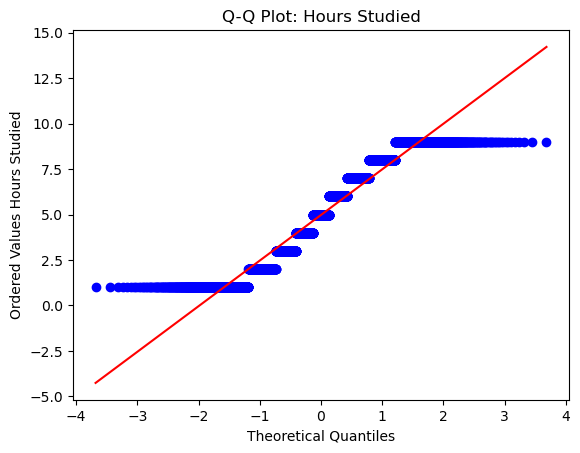

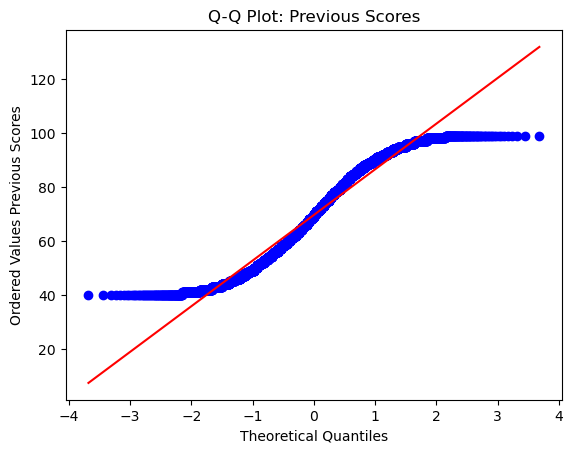

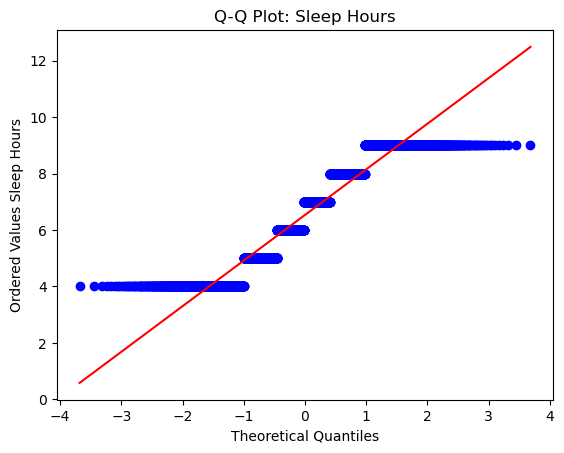

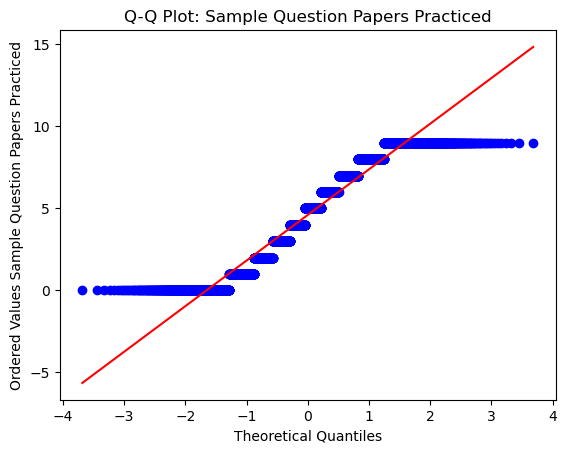

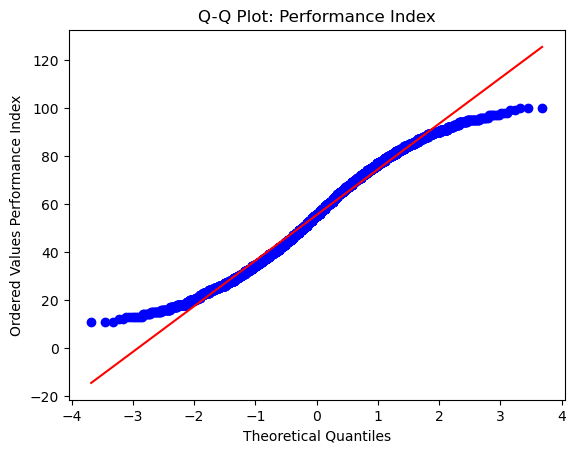

In [24]:
for col in continuous_columns:
    vu.plot_q_q_plot(train_data.copy(), col)

These Q-Q Plots sugges that indeed, the distribution follows normal distribution but there are some sure deviations. Lets plot a histogram or PDE for those to understand better. 

In [25]:
continuous_columns

['Hours Studied',
 'Previous Scores',
 'Sleep Hours',
 'Sample Question Papers Practiced',
 'Performance Index']

<Axes: xlabel='Hours Studied', ylabel='Count'>

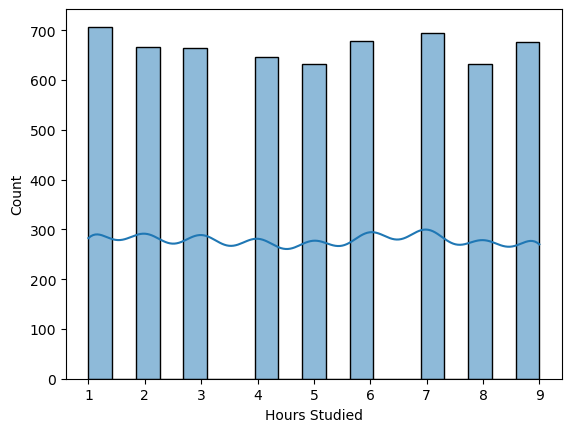

In [26]:
sns.histplot(train_data["Hours Studied"], kde=True)

# Straight Uniform distribution

<Axes: xlabel='Previous Scores', ylabel='Count'>

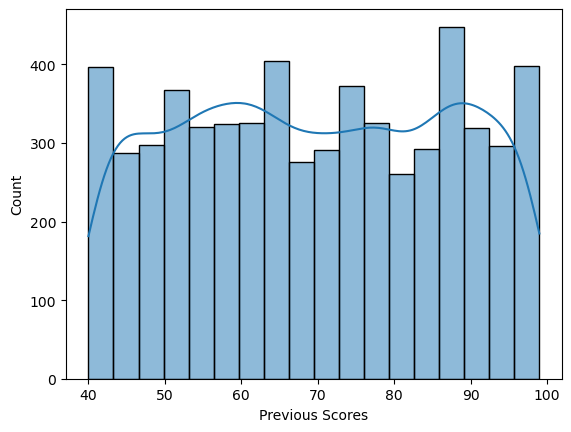

In [27]:
sns.histplot(train_data["Previous Scores"], kde=True)

# Low weight tail, but somewhat normal dist

<Axes: xlabel='Sleep Hours', ylabel='Count'>

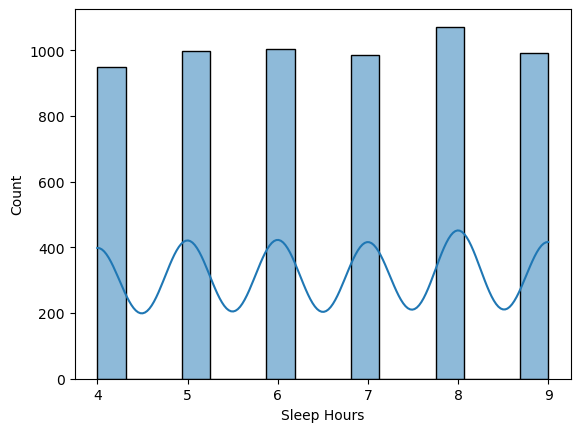

In [28]:
sns.histplot(train_data["Sleep Hours"], kde=True)

# Uniform

<Axes: xlabel='Sample Question Papers Practiced', ylabel='Count'>

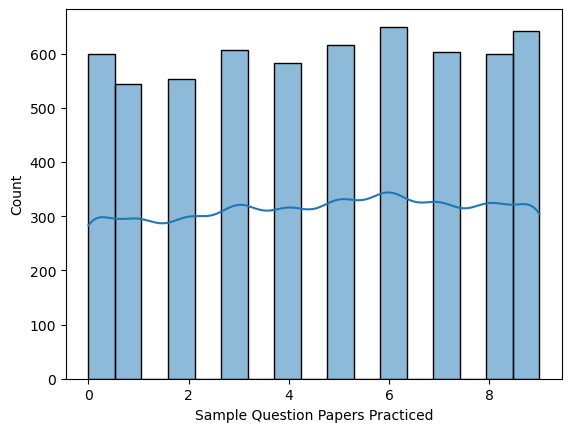

In [29]:
sns.histplot(train_data["Sample Question Papers Practiced"], kde=True)

#Uniform

<Axes: xlabel='Performance Index', ylabel='Count'>

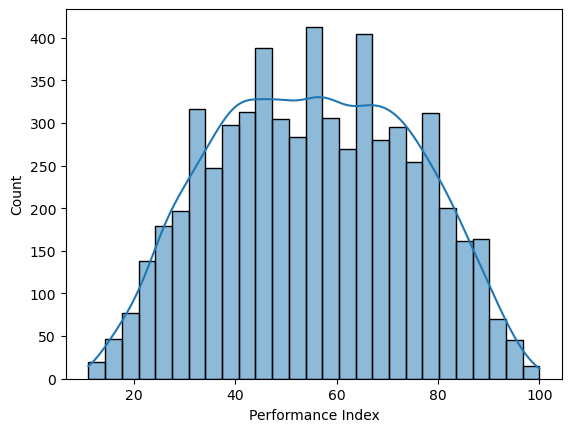

In [30]:
sns.histplot(train_data["Performance Index"], kde=True)

# normal with less tail weight. 

<B>These features are not skewed, they are in some sort of uniform distribution. Thus they can ideally be scaled. No need to apply other methods which changes their distribution. 
    
    But Still will plot Correlation and try to get some featyre to convert it into percentile scaler. 

In [31]:
train_data.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index',
       'Ordered Sample Questions Solved', 'Hours Studied_Z_Score',
       'Hours Studied_Mod_Z_Score', 'Previous Scores_Z_Score',
       'Previous Scores_Mod_Z_Score', 'Sleep Hours_Z_Score',
       'Sleep Hours_Mod_Z_Score', 'Sample Question Papers Practiced_Z_Score',
       'Sample Question Papers Practiced_Mod_Z_Score',
       'Performance Index_Z_Score', 'Performance Index_Mod_Z_Score'],
      dtype='object')

<Axes: >

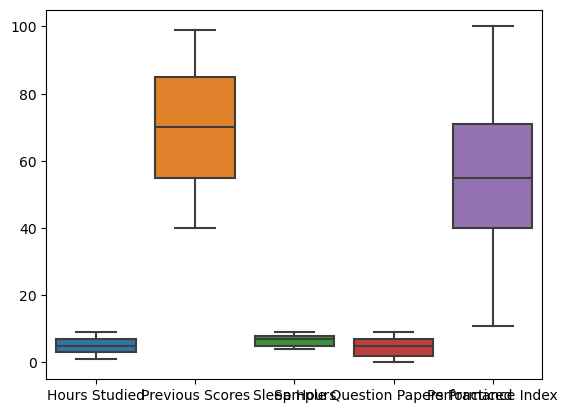

In [32]:
sns.boxplot(train_data[continuous_columns])

<Axes: >

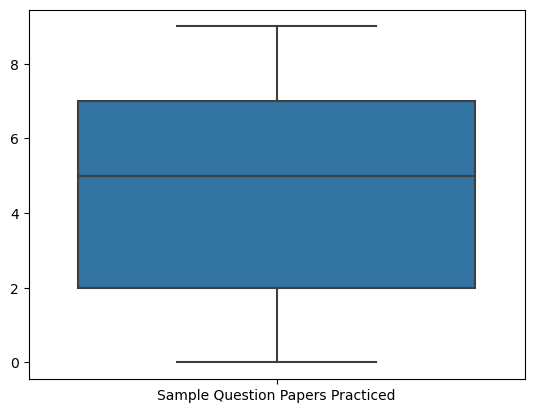

In [33]:
sns.boxplot(train_data[["Sample Question Papers Practiced"]])

The graphs suggest there are no as such outliers in the data. Lets use the z scores to find any such. 

In [34]:
mod_z_scores = [x for x in train_data.columns if "_Mod_Z_Score" in x]
mod_z_scores

['Hours Studied_Mod_Z_Score',
 'Previous Scores_Mod_Z_Score',
 'Sleep Hours_Mod_Z_Score',
 'Sample Question Papers Practiced_Mod_Z_Score',
 'Performance Index_Mod_Z_Score']

In [35]:
train_data[mod_z_scores].describe()

,Hours Studied_Mod_Z_Score,Previous Scores_Mod_Z_Score,Sleep Hours_Mod_Z_Score,Sample Question Papers Practiced_Mod_Z_Score,Performance Index_Mod_Z_Score
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,-0.007644,-0.015536,-0.313755,-0.135125,0.018684
std,0.877149,0.778519,1.144386,0.968550,0.861329
min,-1.349000,-1.349000,-2.023500,-1.686250,-1.978533
25%,-0.674500,-0.674500,-1.349000,-1.011750,-0.674500
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.674500,0.674500,0.674500,0.674500,0.719467
max,1.349000,1.304033,1.349000,1.349000,2.023500


Sleep Hours and Performace Index needs to be checked

In [36]:
train_data[train_data["Sleep Hours_Mod_Z_Score"] < -2][["Sleep Hours"]].describe()

## As the data suggest itself. These are the records where the students get very less sleep.. These are not outliers but actual data suggesting some reocrds where students slept less

,Sleep Hours
count,948.0
mean,4.0
std,0.0
min,4.0
25%,4.0
50%,4.0
75%,4.0
max,4.0


In [37]:
train_data[train_data["Performance Index_Mod_Z_Score"] < -1.9]

# Interesting show, all the students having a low z socre are having previous scores same and their hours studied are in the lower side

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Ordered Sample Questions Solved,Hours Studied_Z_Score,Hours Studied_Mod_Z_Score,Previous Scores_Z_Score,Previous Scores_Mod_Z_Score,Sleep Hours_Z_Score,Sleep Hours_Mod_Z_Score,Sample Question Papers Practiced_Z_Score,Sample Question Papers Practiced_Mod_Z_Score,Performance Index_Z_Score,Performance Index_Mod_Z_Score
3236,1,40,No,9.0,2,11.0,0,-1.529222,-1.34900,-1.712822,-1.349,1.452967,1.3490,-0.905090,-1.01175,-2.318761,-1.978533
3403,1,40,Yes,7.0,6,12.0,2,-1.529222,-1.34900,-1.712822,-1.349,0.274169,0.0000,0.487713,0.33725,-2.266555,-1.933567
5322,2,40,Yes,4.0,2,11.0,0,-1.144738,-1.01175,-1.712822,-1.349,-1.494028,-2.0235,-0.905090,-1.01175,-2.318761,-1.978533
6276,1,40,Yes,6.0,5,11.0,2,-1.529222,-1.34900,-1.712822,-1.349,-0.315230,-0.6745,0.139512,0.00000,-2.318761,-1.978533
784,1,40,No,6.0,3,12.0,1,-1.529222,-1.34900,-1.712822,-1.349,-0.315230,-0.6745,-0.556889,-0.67450,-2.266555,-1.933567


In [38]:
train_data[train_data["Performance Index_Mod_Z_Score"] > 1.9]

# Consistent sleep pattern and previous scores. 

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Ordered Sample Questions Solved,Hours Studied_Z_Score,Hours Studied_Mod_Z_Score,Previous Scores_Z_Score,Previous Scores_Mod_Z_Score,Sleep Hours_Z_Score,Sleep Hours_Mod_Z_Score,Sample Question Papers Practiced_Z_Score,Sample Question Papers Practiced_Mod_Z_Score,Performance Index_Z_Score,Performance Index_Mod_Z_Score
3049,9,99,Yes,5.0,7,99.0,3,1.546652,1.349,1.694974,1.304033,-0.904629,-1.3490,0.835914,0.67450,2.275378,1.978533
2070,9,98,Yes,4.0,5,100.0,2,1.546652,1.349,1.637215,1.259067,-1.494028,-2.0235,0.139512,0.00000,2.327584,2.023500
2725,9,99,Yes,8.0,8,100.0,3,1.546652,1.349,1.694974,1.304033,0.863568,0.6745,1.184115,1.01175,2.327584,2.023500
3040,9,99,Yes,8.0,6,98.0,2,1.546652,1.349,1.694974,1.304033,0.863568,0.6745,0.487713,0.33725,2.223171,1.933567
145,9,98,Yes,7.0,7,100.0,3,1.546652,1.349,1.637215,1.259067,0.274169,0.0000,0.835914,0.67450,2.327584,2.023500
3530,9,99,Yes,5.0,4,98.0,1,1.546652,1.349,1.694974,1.304033,-0.904629,-1.3490,-0.208688,-0.33725,2.223171,1.933567
9305,9,99,Yes,7.0,5,98.0,2,1.546652,1.349,1.694974,1.304033,0.274169,0.0000,0.139512,0.00000,2.223171,1.933567
1077,9,98,Yes,9.0,8,99.0,3,1.546652,1.349,1.637215,1.259067,1.452967,1.3490,1.184115,1.01175,2.275378,1.978533


Seems like, correlation is going to be high for those. 

<Axes: >

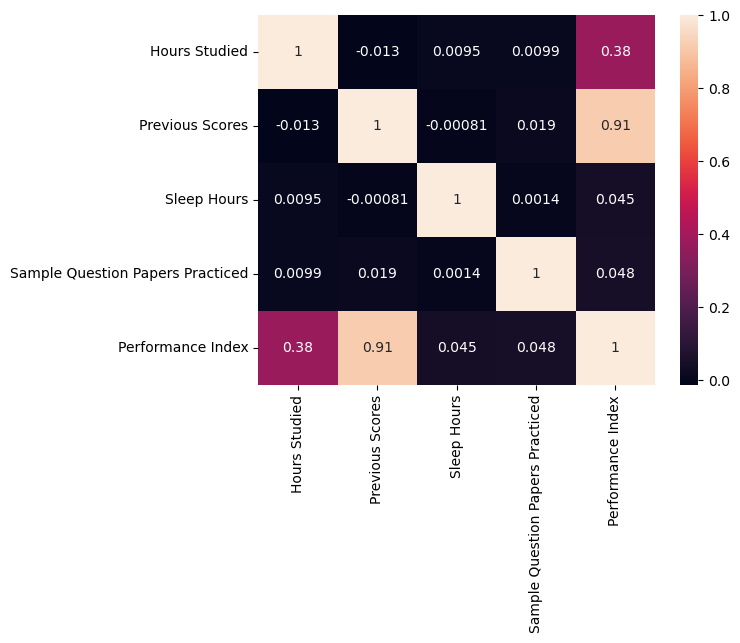

In [39]:
sns.heatmap(train_data[continuous_columns].corr(), annot=True)

<Axes: >

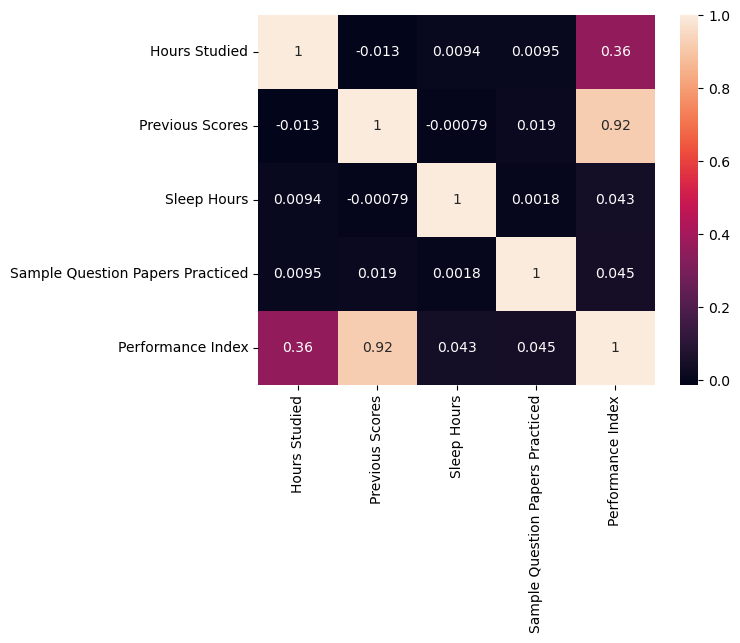

In [40]:
sns.heatmap(train_data[continuous_columns].corr(method="spearman"), annot=True)

In [41]:
train_data.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index',
       'Ordered Sample Questions Solved', 'Hours Studied_Z_Score',
       'Hours Studied_Mod_Z_Score', 'Previous Scores_Z_Score',
       'Previous Scores_Mod_Z_Score', 'Sleep Hours_Z_Score',
       'Sleep Hours_Mod_Z_Score', 'Sample Question Papers Practiced_Z_Score',
       'Sample Question Papers Practiced_Mod_Z_Score',
       'Performance Index_Z_Score', 'Performance Index_Mod_Z_Score'],
      dtype='object')

In [42]:
train_data["Ordered Sample Questions Solved"] = train_data["Ordered Sample Questions Solved"].astype(int)

In [43]:
train_data[["Ordered Sample Questions Solved","Performance Index"]].corr(method="spearman")

,Ordered Sample Questions Solved,Performance Index
Ordered Sample Questions Solved,1.000000,0.046235
Performance Index,0.046235,1.000000


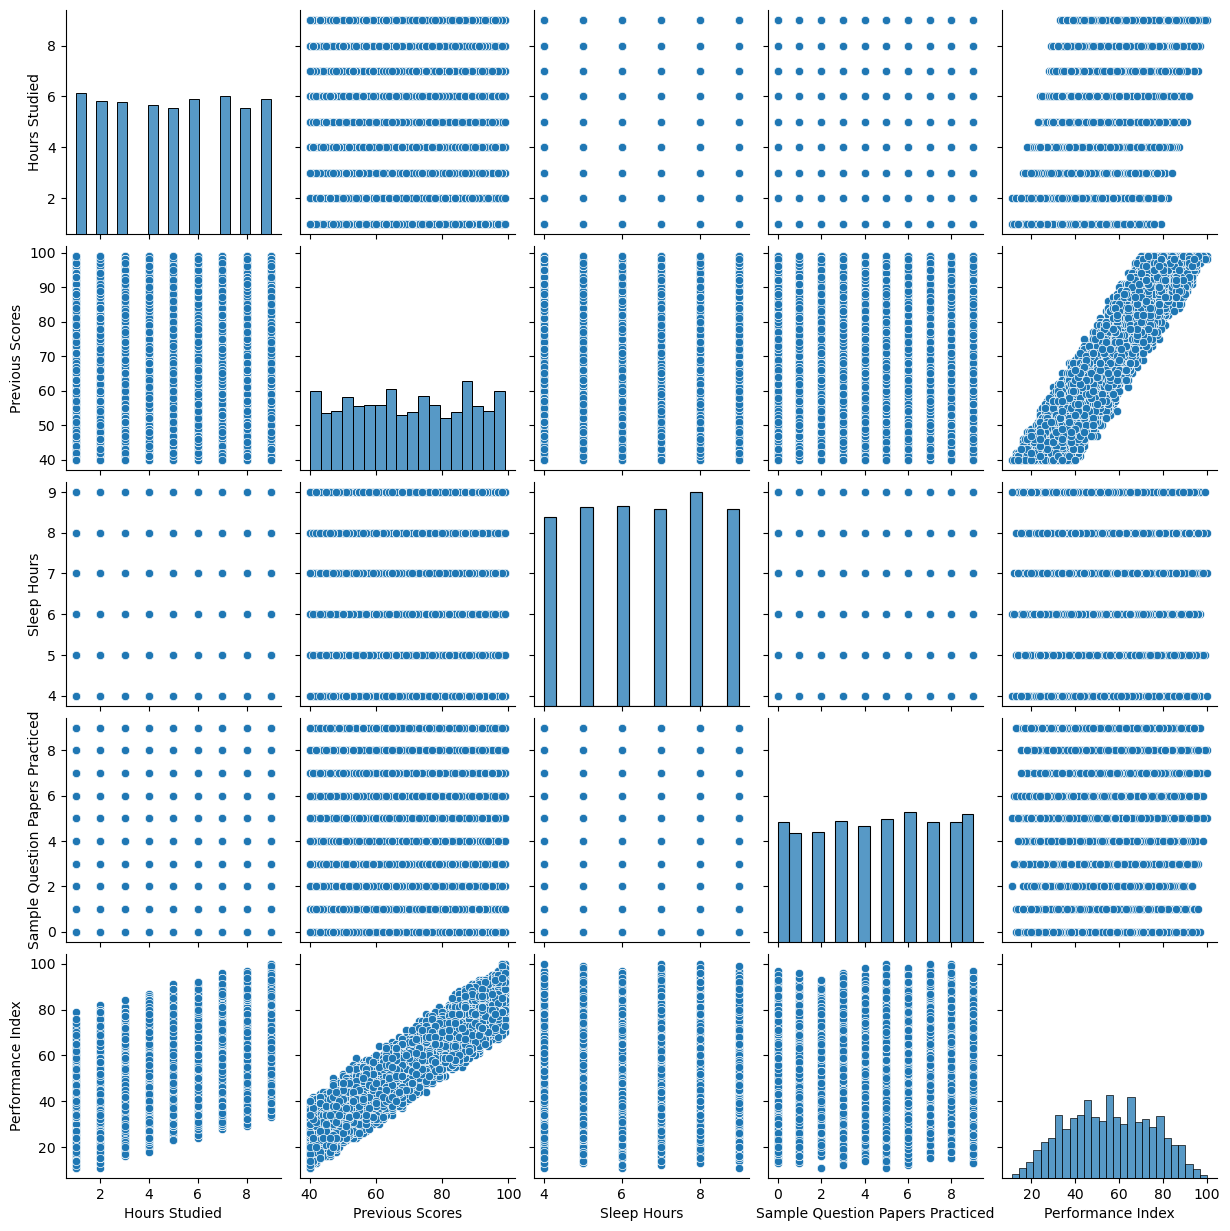

In [44]:
sns.pairplot(train_data[continuous_columns])

The plots at the last row clearly suggests, no need to change the distribution of any feature. Hypothesis testing will be used to consider for hours studied to be included as feature or nor. Clearly sleep hours and sample question papers wont show much. Will Consider this hypothesis while regression testing and evaluation metrics. 

#### Hypothesis Testing

In [45]:
continuous_columns

['Hours Studied',
 'Previous Scores',
 'Sleep Hours',
 'Sample Question Papers Practiced',
 'Performance Index']

In [46]:
# Ho : Are previous scores and the PI have same distributions, mean and variances ? (T-Test) (F-Test) (Cosine Similarity)

# Ho : Is the PI related to the ExtraCurricular activities ? (Anova)

# Ho : Is there any difference between sample question solved and extra curricular activities (ChiSquare)

In [47]:
## Doing the test for 1. 

print(su.two_sample_t_test(train_data.copy(), "Previous Scores", "Performance Index"))

print(su.two_sample_f_test(train_data.copy(), "Previous Scores", "Performance Index"))

print(su.cosine_similarity(train_data.copy(), "Previous Scores", "Performance Index"))

The value of T-Stat is = 42.717327891819636
0.0
Reject Ho: The Mean is significantly different
2.5935582267003926e-15
Reject Ho: The Variance is significantly different
(0.9892263338100964, 0.010773666189903608)


Cosine similarity and correlation stating they are atleast moving In same direction

In [48]:
print(su.two_sample_t_test(train_data.copy(), "Sleep Hours", "Previous Scores"))

print(su.two_sample_f_test(train_data.copy(), "Sleep Hours", "Previous Scores"))

print(su.cosine_similarity(train_data.copy(), "Sleep Hours", "Previous Scores"))

The value of T-Stat is = -281.0518644014241
0.0
Reject Ho: The Mean is significantly different
0.0
Reject Ho: The Variance is significantly different
(0.9392883411903399, 0.06071165880966012)


In [49]:
print(su.two_sample_t_test(train_data.copy(), "Sleep Hours", "Performance Index"))

print(su.two_sample_f_test(train_data.copy(), "Sleep Hours", "Performance Index"))

print(su.cosine_similarity(train_data.copy(), "Sleep Hours", "Performance Index"))

The value of T-Stat is = -196.89611838938546
0.0
Reject Ho: The Mean is significantly different
0.0
Reject Ho: The Variance is significantly different
(0.9184725303286594, 0.08152746967134061)


In [50]:
cosine_similarity = dict()
for x in continuous_columns:
    cosine_similarity[x] = su.cosine_similarity(train_data.copy(), x, "Performance Index")

In [51]:
cosine_similarity

{'Hours Studied': (0.8947701839196484, 0.10522981608035165),
 'Previous Scores': (0.9892263338100964, 0.010773666189903608),
 'Sleep Hours': (0.9184725303286594, 0.08152746967134061),
 'Sample Question Papers Practiced': (0.8100240182860139, 0.1899759817139861),
 'Performance Index': (0.9999999999999998, 2.220446049250313e-16)}

In [52]:
print(su.two_sample_t_test(train_data.copy(), "Sample Question Papers Practiced", "Performance Index"))

print(su.two_sample_f_test(train_data.copy(), "Sample Question Papers Practiced", "Performance Index"))

print(su.cosine_similarity(train_data.copy(), "Sample Question Papers Practiced", "Performance Index"))

The value of T-Stat is = -203.22244090258945
0.0
Reject Ho: The Mean is significantly different
0.0
Reject Ho: The Variance is significantly different
(0.8100240182860139, 0.1899759817139861)


<B> T test, F test and Cosine similarity clearly suggests out of Sample Question Papers Practiced others can be used

In [53]:
train_data.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index',
       'Ordered Sample Questions Solved', 'Hours Studied_Z_Score',
       'Hours Studied_Mod_Z_Score', 'Previous Scores_Z_Score',
       'Previous Scores_Mod_Z_Score', 'Sleep Hours_Z_Score',
       'Sleep Hours_Mod_Z_Score', 'Sample Question Papers Practiced_Z_Score',
       'Sample Question Papers Practiced_Mod_Z_Score',
       'Performance Index_Z_Score', 'Performance Index_Mod_Z_Score'],
      dtype='object')

In [54]:
print(su.anova_test(train_data.copy(), "Extracurricular Activities", "Performance Index"))

The Value of F-stat is 3.473607503624003
Failed To reject Ho: Means are same


The means are same, there is no significant difference in doing or not doing extra-c activities. 

In [55]:
# lets check
train_data.groupby("Extracurricular Activities")["Performance Index"].describe().T

# Actually there is no diff. 

Extracurricular Activities,No,Yes
count,3085.000000,2915.000000
mean,54.967585,55.889537
std,19.003641,19.305516
min,11.000000,11.000000
25%,40.000000,41.000000
50%,55.000000,56.000000
75%,70.000000,71.500000
max,97.000000,100.000000


In [56]:
train_data.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index',
       'Ordered Sample Questions Solved', 'Hours Studied_Z_Score',
       'Hours Studied_Mod_Z_Score', 'Previous Scores_Z_Score',
       'Previous Scores_Mod_Z_Score', 'Sleep Hours_Z_Score',
       'Sleep Hours_Mod_Z_Score', 'Sample Question Papers Practiced_Z_Score',
       'Sample Question Papers Practiced_Mod_Z_Score',
       'Performance Index_Z_Score', 'Performance Index_Mod_Z_Score'],
      dtype='object')

In [57]:
print(su.chi_square_test(train_data.copy(), "Ordered Sample Questions Solved", "Extracurricular Activities"))

The Stats: statistic=1.8540007924004804, p-value=0.7625891943360372, dof=4
Failed To reject Ho: distribution are same


#### Standard Scaling

In [60]:
continuous_columns

['Hours Studied',
 'Previous Scores',
 'Sleep Hours',
 'Sample Question Papers Practiced',
 'Performance Index']

In [61]:
train_data, scaling_obj = st.scale_data_sklearn(train_data.copy(), continuous_columns)

In [63]:
train_data.head(4)

,Extracurricular Activities,Ordered Sample Questions Solved,Hours Studied_Z_Score,Hours Studied_Mod_Z_Score,Previous Scores_Z_Score,Previous Scores_Mod_Z_Score,Sleep Hours_Z_Score,Sleep Hours_Mod_Z_Score,Sample Question Papers Practiced_Z_Score,Sample Question Papers Practiced_Mod_Z_Score,Performance Index_Z_Score,Performance Index_Mod_Z_Score,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,No,0,0.393199,0.33725,0.539789,0.404700,-0.904629,-1.3490,-1.253291,-1.34900,0.761400,0.674500,0.393232,0.539834,-0.904705,-1.253395,0.761464
1,No,2,-0.375769,-0.33725,0.308752,0.224833,0.863568,0.6745,0.487713,0.33725,0.239339,0.224833,-0.375801,0.308778,0.863640,0.487754,0.239359
2,No,0,-0.760253,-0.67450,0.308752,0.224833,0.863568,0.6745,-1.253291,-1.34900,-0.021692,0.000000,-0.760317,0.308778,0.863640,-1.253395,-0.021693
3,Yes,4,1.546652,1.34900,0.597548,0.449667,1.452967,1.3490,1.532316,1.34900,1.231255,1.079200,1.546781,0.597598,1.453088,1.532444,1.231358


In [67]:
test_data, _ = st.scale_data_sklearn(test_data.copy(), continuous_columns, scaling_obj, fit=False)

In [68]:
test_data.head(5)

,Extracurricular Activities,Ordered Sample Questions Solved,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,Yes,3,-1.319103,-4.099118,-2.995425,-1.189247,-2.921661
1,Yes,3,-2.206220,-3.935620,-4.037772,-1.189247,-2.828979
2,Yes,1,-1.614809,-4.069088,-3.342874,-1.795567,-2.910757
3,Yes,0,-2.501925,-4.065751,-4.037772,-2.038095,-2.965276
4,No,3,-1.466956,-3.978997,-3.690323,-1.189247,-2.828979
